In [1]:
import os
import pandas as pd



In [2]:
df = pd.read_excel('./data_without_extra_features/SEFACED.xlsx')

df.to_csv('./data_without_extra_features/SEFACED.csv', index=False)

In [3]:
# normal, fraudulent

# CSV dosyasını pandas DataFrame'e yükle
df = pd.read_csv('./data_without_extra_features/SEFACED.csv')

normal_rows = df[df['Class_Label'] == 'Normal']

fraudulent_rows = df[df['Class_Label'] == 'Fraudulent']

filtered_df = pd.concat([normal_rows, fraudulent_rows])

filtered_df.to_csv('./data_without_extra_features/SEFACED_12000.csv', index=False)

In [4]:
df1 = pd.read_csv("./data_without_extra_features/SEFACED_12000.csv")

In [5]:
print(df1.head())

print(df1.info())

print(df1.describe())

                                                Text Class_Label
0  Let me know when you get the quotes from Pauli...      Normal
1  ---------------------- Forwarded by Phillip K ...      Normal
2  Steve, Please remove Bob Shiring and Liz River...      Normal
3  Go ahead and order the ac for #27. Can you ema...      Normal
4  Anymore details? Is the offer above or below 6...      Normal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17640 entries, 0 to 17639
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Text         17541 non-null  object
 1   Class_Label  17640 non-null  object
dtypes: object(2)
memory usage: 275.8+ KB
None
                                                    Text Class_Label
count                                              17541       17640
unique                                             10670           2
top     <html><head><style>P{margin:0px;padding:0px}body      Normal
freq           

In [6]:


import re


def load_stopwords(stopwords_file):
    with open(stopwords_file, 'r') as file:
        stopwords = file.read().splitlines()
    return stopwords


def clean_text(text, stopwords):
    if isinstance(text, str):
        # Küçük harfe çevir
        lowercase_text = text.lower()

        # Bağlantıları kaldır
        text_no_links = re.sub(r'http\S+|www.\S+|\.com|\w+@\w+\.\w+', '', lowercase_text)

        # HTML etiketlerini kaldır
        clean_html = re.sub(r'<.*?>', '', text_no_links)

        # Rakamları kaldır
        text_no_digits = re.sub(r'\d+', '', clean_html)

        # Özel karakterleri kaldır
        text_no_special_chars = re.sub(r'[^a-zA-Z0-9\s]', '', text_no_digits)

        # Metni tokenlara ayır
        tokens = text_no_special_chars.split()

        # Stop kelimelerini kaldır
        filtered_tokens = [token for token in tokens if token not in stopwords]

        # Tokenları tekrar metne birleştir
        clean_text = ' '.join(filtered_tokens)

        return clean_text

def clean_csv(input_csv, output_csv, stopwords_file):
    df = pd.read_csv(input_csv)
    stopwords = load_stopwords(stopwords_file)

    df['cleaned_text'] = df['Text'].apply(lambda x: clean_text(x, stopwords))
    df = df.drop('Text', axis=1)

    df.to_csv(output_csv, index=False)

input_csv_file = './data_without_extra_features/SEFACED_12000.csv'
output_csv_file = './data_without_extra_features/preprocessed_SEFACED.csv' 
stopwords_file = './stopwords.txt'

clean_csv(input_csv_file, output_csv_file, stopwords_file)


In [7]:
import pandas as pd
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize


def tokenize_text(text):
    # Metnin bir dize olup olmadığını kontrol et veya dizeye dönüştür
    if isinstance(text, str):
        tokens = word_tokenize(text)
        return tokens
    else:
        # Girişin bir dize olmadığı durumda boş bir liste döndür
        return []

def tokenize_csv(input_csv, output_csv):
    
    df = pd.read_csv(input_csv)

    df['tokens'] = df['cleaned_text'].apply(tokenize_text)
    df = df.drop('cleaned_text', axis=1)

    df.to_csv(output_csv, index=False)

input_csv_file = './data_without_extra_features/preprocessed_SEFACED.csv'  
output_csv_file = './data_without_extra_features/tokenized_SEFACED.csv' 

tokenize_csv(input_csv_file, output_csv_file)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\orange\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# Lemmatization and removing misspelled words

import pandas as pd
import nltk
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
import ast

nltk.download('wordnet')
nltk.download('words')

# Load English words
english_words = set(words.words())

# Function to lemmatize tokens
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Function to remove misspelled words
def remove_misspelled(tokens):
    return [token for token in tokens if token in english_words]

# Function to remove empty lines and get removed indices
def remove_empty_lines(df):
    # Convert empty lists to NaN values
    df['lemmatized_tokens'] = df['lemmatized_tokens'].apply(lambda x: x if x else float('nan'))
    # Get indices of rows with empty 'lemmatized_tokens'
    removed_indices = df.index[df['lemmatized_tokens'].apply(lambda x: isinstance(x, float))].tolist()
    # Drop rows with NaN values in 'lemmatized_tokens'
    df = df.dropna(subset=['lemmatized_tokens'])
    return df, removed_indices

# Function to lemmatize tokens and remove misspelled words from a CSV
def lemmatize_csv(input_csv, output_csv):
    # Read the CSV file
    df = pd.read_csv(input_csv)

    # Convert 'tokens' column from string to list
    df['tokens'] = df['tokens'].apply(ast.literal_eval)

    # Lemmatize tokens
    df['lemmatized_tokens'] = df['tokens'].apply(lemmatize_tokens)

    # Remove misspelled words
    df['lemmatized_tokens'] = df['lemmatized_tokens'].apply(remove_misspelled)

    # Remove empty lines and get removed indices
    df, removed_indices = remove_empty_lines(df)

    # Drop the original 'tokens' column
    df = df.drop('tokens', axis=1)

    # Save the lemmatized data to a new CSV file
    df.to_csv(output_csv, index=False)

    return removed_indices

# Function to remove same lines from original CSV based on removed indices
def remove_same_lines_from_original(removed_indices, original_csv):
    # Load the original CSV
    original_df = pd.read_csv(original_csv)
    # Remove the corresponding rows from the original file
    cleaned_original_df = original_df.drop(removed_indices)
    # Save the cleaned original file
    cleaned_original_df.to_csv(original_csv, index=False)

# Input and output file paths
input_csv_file = './data_without_extra_features/tokenized_SEFACED.csv'
output_csv_file = './data_without_extra_features/lemmatized_and_misspelled_removed_SEFACED.csv'
original_csv_file = './data_without_extra_features/SEFACED_12000.csv' # With extra features'da kullanmak icin

# Lemmatize and remove misspelled words from the input CSV
removed_indices = lemmatize_csv(input_csv_file, output_csv_file)

# Remove same lines from the original CSV
remove_same_lines_from_original(removed_indices, original_csv_file)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\orange\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\orange\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv('./data_without_extra_features/lemmatized_and_misspelled_removed_SEFACED.csv', encoding='utf-8')

corpus = df['lemmatized_tokens']

vectorizer = CountVectorizer()

X_bow = vectorizer.fit_transform(corpus)

df_bow = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())

print(df_bow)




       aa  aba  abandon  abandoned  abandonment  abased  abatement  abb  \
0       0    0        0          0            0       0          0    0   
1       0    0        0          0            0       0          0    0   
2       0    0        0          0            0       0          0    0   
3       0    0        0          0            0       0          0    0   
4       0    0        0          0            0       0          0    0   
...    ..  ...      ...        ...          ...     ...        ...  ...   
17110   0    0        0          0            0       0          0    0   
17111   0    0        0          0            0       0          0    0   
17112   0    0        0          0            0       0          0    0   
17113   0    0        0          0            0       0          0    0   
17114   0    0        0          0            0       0          0    0   

       abbas  abbey  ...  zinc  zinfandel  zing  zip  zipper  zonal  zone  \
0          0      0  .

In [2]:
# splitting data
 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, classification_report
import joblib


y = df['Class_Label']

X_train, X_test, y_train, y_test = train_test_split(df_bow, y, test_size=0.2, random_state=42)

In [13]:
# To be used in the deep learning algorithms

y.to_csv("labels.csv", index=False)
df_bow.to_csv("bow.csv", index= False)

Logistic Regression Classifier:
Accuracy: 0.983640081799591
Precision: 0.9833603896103896
Recall: 0.9938474159146842
F1 Score: 0.988576091391269


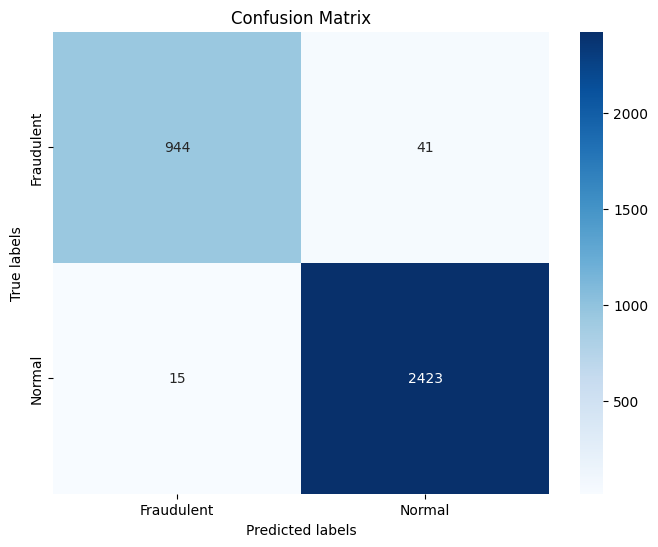

In [4]:
# Logistic regression

from sklearn.metrics import precision_score, recall_score, classification_report, f1_score


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



lr_model = LogisticRegression(max_iter=10000)  
lr_model.fit(X_train, y_train)

lr_predictions = model.predict(X_test)

# Modeli değerlendir
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_precision = precision_score(y_test, lr_predictions, pos_label='Normal')
lr_recall = recall_score(y_test, lr_predictions, pos_label='Normal')
lr_f1_score = f1_score(y_test, lr_predictions, pos_label='Normal')

print("Logistic Regression Classifier:")
print(f"Accuracy: {lr_accuracy}")
print(f"Precision: {lr_precision}")
print(f"Recall: {lr_recall}")
print("F1 Score:", lr_f1_score)
# print("Sınıflandırma Raporu:")
# print(classification_report(y_test, lr_predictions))

# Compute confusion matrix
cm = confusion_matrix(y_test, lr_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Random Forest Classifier:
Accuracy: 0.9865614957639498
Precision: 0.9869706840390879
Recall: 0.9942575881870386
F1 Score: 0.9906007355946056


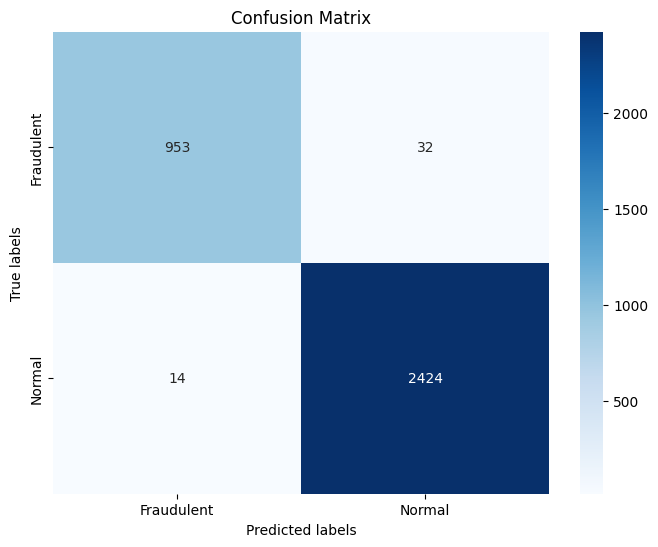

In [5]:
#RF

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, classification_report, f1_score
import seaborn as sns


rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

# Modeli değerlendir
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions, pos_label='Normal')
rf_recall = recall_score(y_test, rf_predictions, pos_label='Normal')
rf_f1_score = f1_score(y_test, rf_predictions, pos_label='Normal')


print("Random Forest Classifier:")
print(f"Accuracy: {rf_accuracy}")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print("F1 Score:", rf_f1_score)

# print("Sınıflandırma Raporu:")
# print(classification_report(y_test, rf_predictions))

# Compute confusion matrix
cm = confusion_matrix(y_test, rf_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



Naive Bayes Classifier:
Accuracy: 0.9763365468886941
Precision: 0.9757771497779572
Recall: 0.9913863822805579
F1-score: 0.9835198372329603


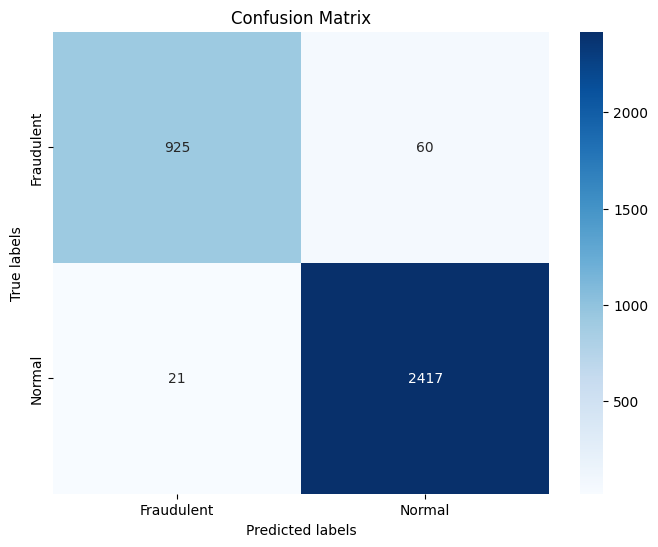

In [6]:
# NB

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, classification_report
import seaborn as sns


nb_model = MultinomialNB()

nb_model.fit(X_train, y_train)

nb_predictions = nb_model.predict(X_test)

# Modeli değerlendir
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision = precision_score(y_test, nb_predictions, pos_label='Normal')
nb_recall = recall_score(y_test, nb_predictions, pos_label='Normal')
nb_f1_score = f1_score(y_test, nb_predictions, pos_label='Normal')


print("Naive Bayes Classifier:")
print(f"Accuracy: {nb_accuracy}")
print(f"Precision: {nb_precision}")
print(f"Recall: {nb_recall}")
print(f"F1-score: {nb_f1_score}")
# print("Sınıflandırma Raporu:")
# print(classification_report(y_test, nb_predictions))

# Compute confusion matrix
cm = confusion_matrix(y_test, nb_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()





Support Vector Machine Classifier (LinearSVC):
Accuracy: 0.9851007887817704
Precision: 0.9857549857549858
Recall: 0.9934372436423298
f1_score: 0.9895812053115424


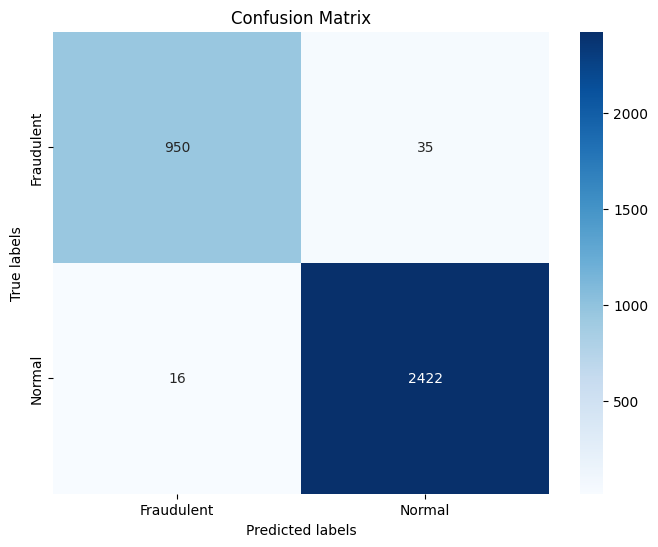

In [7]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


svm_model = LinearSVC(max_iter=1000000)
svm_model.fit(X_train, y_train)

svm_predictions = svm_model.predict(X_test)


svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions, pos_label='Normal')
svm_recall = recall_score(y_test, svm_predictions, pos_label='Normal')
svm_f1_score = f1_score(y_test, svm_predictions, pos_label='Normal')

print("Support Vector Machine Classifier (LinearSVC):")
print(f"Accuracy: {svm_accuracy}")
print(f"Precision: {svm_precision}")
print(f"Recall: {svm_recall}")
print(f"f1_score: {svm_f1_score}")

# print("Classification Report:")
# print(classification_report(y_test, svm_predictions))

cm = confusion_matrix(y_test, svm_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

(17115, 12851)
(17115, 1)
Normal


C:\Users\orange\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Neural Network Model Summary: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 10)                128520    
                                                                 
 fc2 (Dense)                 (None, 10)                110       
                                                                 
 output (Dense)              (None, 2)                 22        
                                                                 
Total params: 128,652
Trainable params: 128,652
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
2739/2739 - 14s - loss: 0.1040 - accuracy: 0.9622 - 14s/epoch - 5ms/step
Epoch 2/200
2739/2739 - 10s - loss: 0.0244 - accuracy: 0.9915 - 10s/epoch - 4ms/step
Epoch 3/200
2739/2739 - 10s - loss: 0.0111 - accuracy: 0.9958 - 10s/epoch - 4ms/step
Epoch 4/200
2739/2739 -

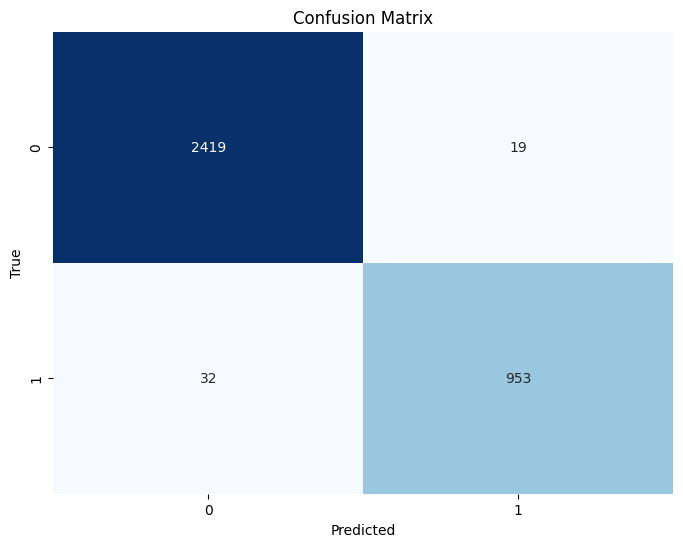

In [8]:
#LSTM
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

df = pd.read_csv("./bow.csv")
x = df.values

y_ = pd.read_csv("./labels.csv")
print(x.shape)
print(y_.shape)

print(y_["Class_Label"].iloc[2])

y = []
i = 0
while i < 17115 :
        if y_["Class_Label"].iloc[i] == "Normal":
                y.append(0)
        else:
                y.append(1)
        i += 1

y = np.array(y)
y_ = y.reshape(-1, 1)



# One Hot encode the class labels
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y_)

# Split the data for training and testing
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.20, random_state=42)

# Build the model

model = Sequential()

model.add(Dense(10, input_shape=(12851,), activation='relu', name='fc1'))
model.add(Dense(10, activation='relu', name='fc2'))
model.add(Dense(2, activation='softmax', name='output'))

# Adam optimizer with learning rate of 0.001
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print('Neural Network Model Summary: ')
print(model.summary())

# Train the model
model.fit(train_x, train_y, verbose=2, batch_size=5, epochs=200)

y_pred = model.predict(test_x)

y_pred_classes = np.argmax(y_pred, axis=1)
test_y_classes = np.argmax(test_y, axis=1)

lstm_accuracy = accuracy_score(test_y_classes, y_pred_classes )
lstm_precision = precision_score(test_y_classes, y_pred_classes )
lstm_recall = recall_score(test_y_classes, y_pred_classes )
lstm_f1_score = f1_score(test_y_classes, y_pred_classes )



print(f"Accuracy: {lstm_accuracy}")
print(f"Precision: {lstm_precision}")
print(f"Recall: {lstm_recall}")
print(f"F1-score: {lstm_f1_score}")

# Compute confusion matrix
cm = confusion_matrix(test_y_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



C:\Users\orange\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Neural Network Model Summary: 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12849, 64)         256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6424, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 6422, 32)          6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3211, 32)         0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 102752)            0         
                                                                 
 dense (Dense)         

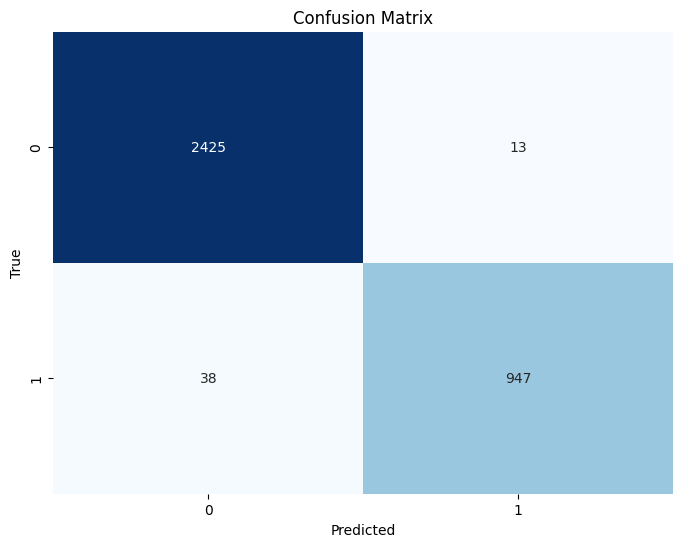

In [10]:
# CNN

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam

df = pd.read_csv("./bow.csv")
x = df.values

y_ = pd.read_csv("./labels.csv")

y = []
for label in y_["Class_Label"]:
    if label == "Normal":
        y.append(0)
    else:
        y.append(1)

y = np.array(y)
y_ = y.reshape(-1, 1)

# One Hot encode the class labels
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y_)

# Split the data for training and testing
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.20, random_state=42)

# Reshape input data for CNN (samples, features, channels)
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], 1)
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], 1)

# Build the CNN model
model = Sequential()

model.add(Conv1D(64, 3, activation='relu', input_shape=(12851, 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Adam optimizer with learning rate of 0.001
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print('Neural Network Model Summary: ')
print(model.summary())

# Train the model
model.fit(train_x, train_y, verbose=2, batch_size=32, epochs=10)

y_pred = model.predict(test_x)

y_pred_classes = np.argmax(y_pred, axis=1)
test_y_classes = np.argmax(test_y, axis=1)

cnn_accuracy = accuracy_score(test_y_classes, y_pred_classes )
cnn_precision = precision_score(test_y_classes, y_pred_classes )
cnn_recall = recall_score(test_y_classes, y_pred_classes )
cnn_f1_score = f1_score(test_y_classes, y_pred_classes )



print(f"Accuracy: {cnn_accuracy}")
print(f"Precision: {cnn_precision}")
print(f"Recall: {cnn_recall}")
print(f"F1-score: {cnn_f1_score}")

# Compute confusion matrix
cm = confusion_matrix(test_y_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
